In [1]:
import json
import random
from pathlib import Path

import pandas as pd

%load_ext autoreload
%autoreload 2
Path.ls = lambda x: list(x.iterdir())

In [2]:
# !pip install --upgrade xlrd

In [3]:
assam_travel_history = Path("AssamTravelHistory.xlsx").resolve()
# pd.read_excel("AssamTravelHistory.xlsx", sheet_name=10)
xl = pd.ExcelFile(assam_travel_history)

In [4]:
def read_assam_excel_to_df(filename:str)->pd.DataFrame:
    xl = pd.ExcelFile(filename)
    df_list = []
    for sheet_name in xl.sheet_names:
        district_df = xl.parse(sheet_name)
        district_df["District"] = sheet_name
        district_df.drop(columns=["S.No."], inplace=True)
        df_list.append(district_df)
    return pd.concat(df_list, sort=False)

df = read_assam_excel_to_df(assam_travel_history)

In [5]:
df["DateOfArrival"] = pd.to_datetime(df["Date of arrival"])
df["DateOfReturn"] = pd.to_datetime(df["Date of Receipt"])
df.drop(columns=["Date of arrival", "Date of Receipt"], inplace=True)

In [6]:
# len(df)

In [7]:
df_copy = df
df_copy["Inflow"] = 1
assam_traveller_count_df = df_copy.groupby("District").agg({"Inflow": "sum"})
assam_traveller_count_df.reset_index(inplace=True)

In [8]:
def clean_district_names(dname: str):
    input_to_output_mapping = {
        "Cacher": "Cachar",
        "Kamrup_M": "Kamrup Metropolitan",
        "Kamrup_R": "Kamrup",
        "KarbiAnlong": "Karbi Anglong",
        "Baksha": "Baksa",
    }
    return input_to_output_mapping.get(dname, dname)

In [9]:
assam_traveller_count_df["District"] = assam_traveller_count_df.District.apply(clean_district_names)

In [10]:
assam_pop_web_raw = pd.read_html("https://www.census2011.co.in/census/state/districtlist/assam.html")
assam_pop_web_raw = assam_pop_web_raw[0][["District", "Population"]]
assam_pop_df = assam_pop_web_raw[~(assam_pop_web_raw["District"].apply(lambda x: len(x)) > 21)]
# assam_pop_df

In [11]:
assam_df = pd.merge(assam_pop_df, assam_traveller_count_df, on="District", how="left")

# Running SIERS Plus for Assam
## Challenge: Assam has zero cases right now

In [12]:
# !pip install seirsplus
# from https://github.com/ryansmcgee/seirsplus

In [13]:
import contextlib
import io
import sys

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

In [14]:
from seirsplus.models import *
import networkx

In [15]:
from typing import List


def get_infections(
    initI: int = 100, initN: int = 10 ** 5, days_N: int = 21
) -> List[int]:
    model = SEIRSModel(
        beta=1.8,
        sigma=1 / 5.2,
        gamma=1 / 12.39,
        initN=initN,
        initI=initI,
        beta_D=0.000,
        mu_D=0.02,
        #         sigma_D=1 / 4.0,
        #         gamma_D=1 / 9.0,
        theta_E=0.0002,
        theta_I=0.002,
        psi_E=0.2,
        psi_I=1.0,
    )
#     with nostdout():
    model.run(T=days_N)
    S = model.numS  # time series of S counts
    E = model.numE  # time series of E counts
    I = model.numI  # time series of I counts
    D_E = model.numD_E  # time series of D_E counts
    D_I = model.numD_I  # time series of D_I counts
    R = model.numR  # time series of R counts
    F = model.numF  # time series of F counts
    t = model.tseries  # time values corresponding to the above time series
    return {"detected_exposed": D_E, "detected_infected": D_I, "model": model, "t": t}

In [16]:
# model = get_infections()["model"]
# ?model.figure_infections
# model.figure_infections(
#     plot_percentages=False,
#     plot_D_E=False,
#     title="Worst Case Scenario",
#     plot_E=False,
#     plot_I=False,
#     color_D_I='tab:red'
# )

In [17]:
percent_travellers_infected = 10**-3
unknown_to_known_travelers = 10

assam_estimated_df = assam_df
assam_estimated_df["initI"] = percent_travellers_infected * unknown_to_known_travelers * assam_df["Inflow"]
assam_estimated_df["initN"] = assam_estimated_df["Population"]

t = 20.90


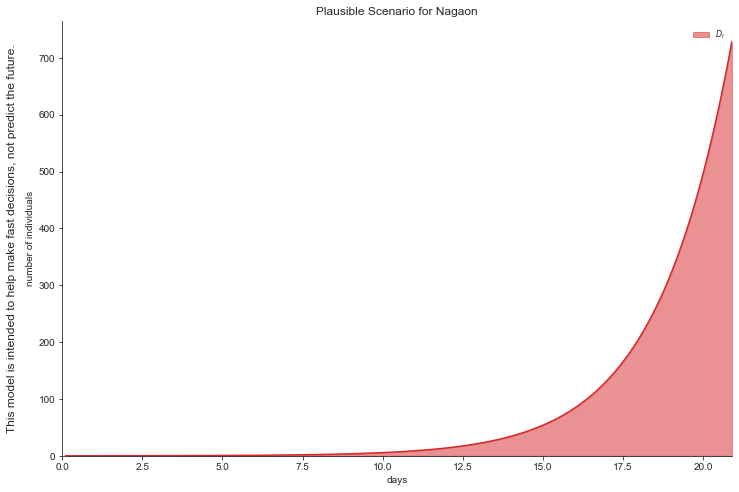

32 728
t = 20.90


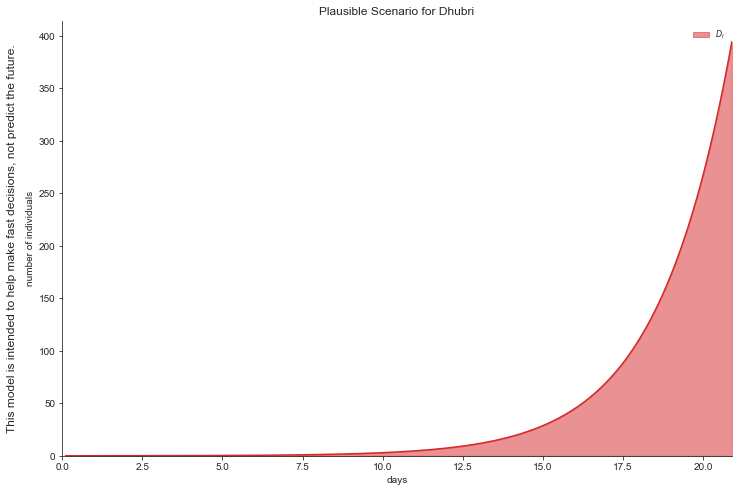

17 394
t = 20.90


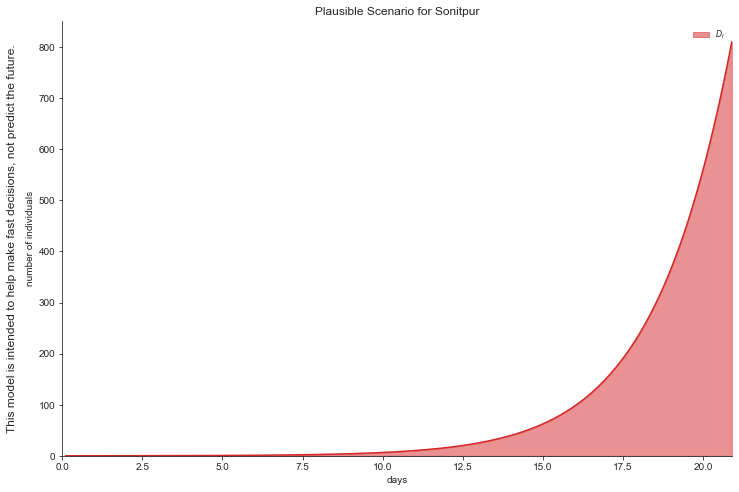

38 810
t = 20.90


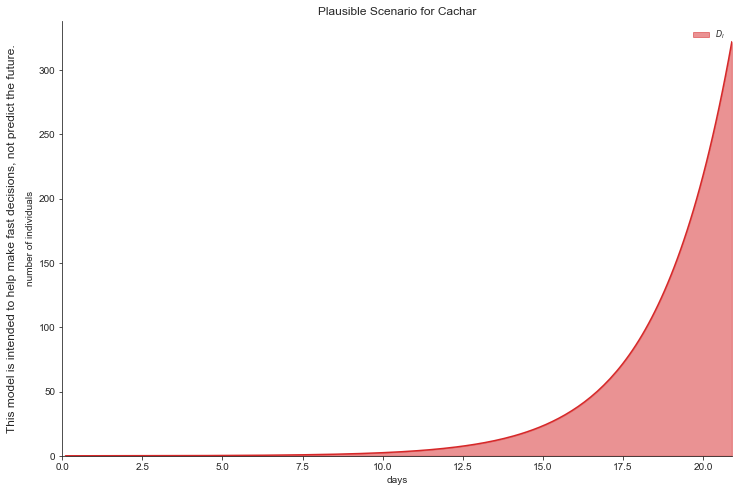

14 322
t = 20.90


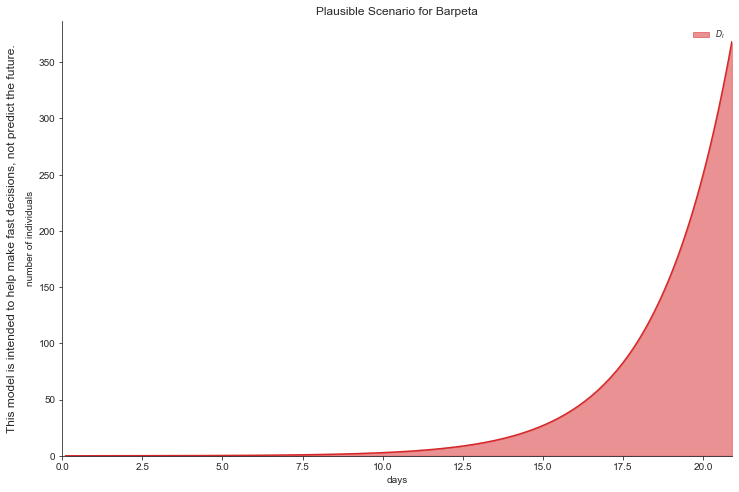

16 368
t = 20.90


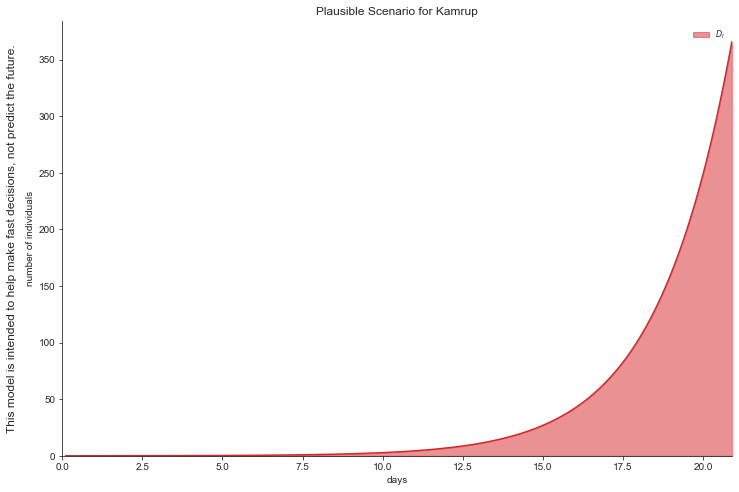

16 365
t = 20.90


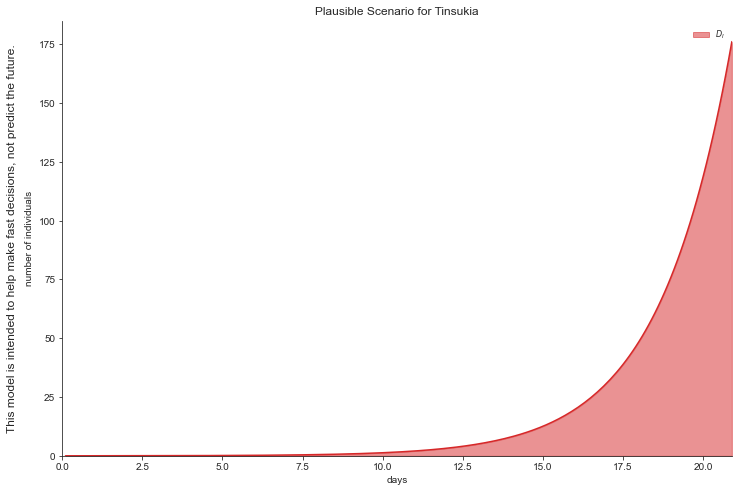

7 176
t = 20.90


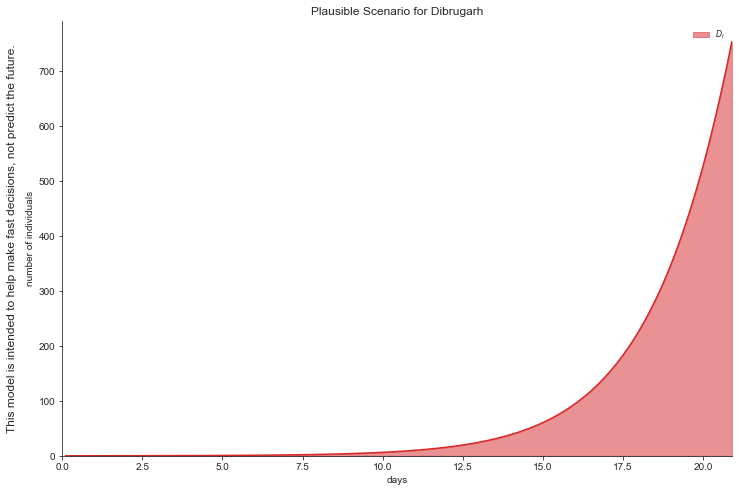

36 753
t = 20.90


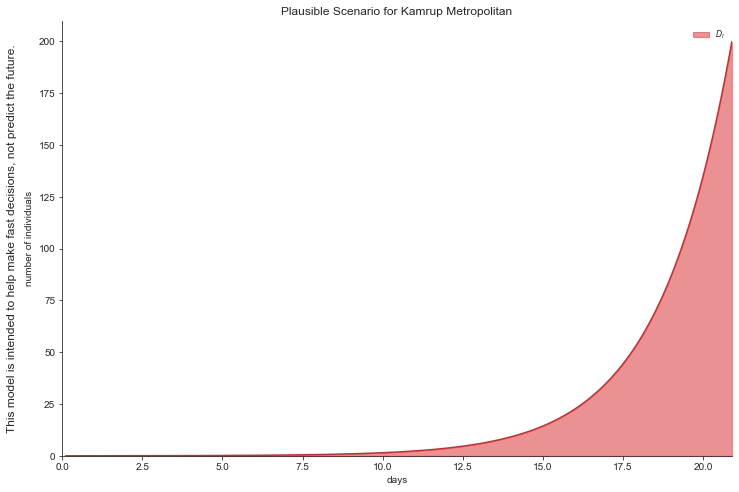

8 199
t = 20.90


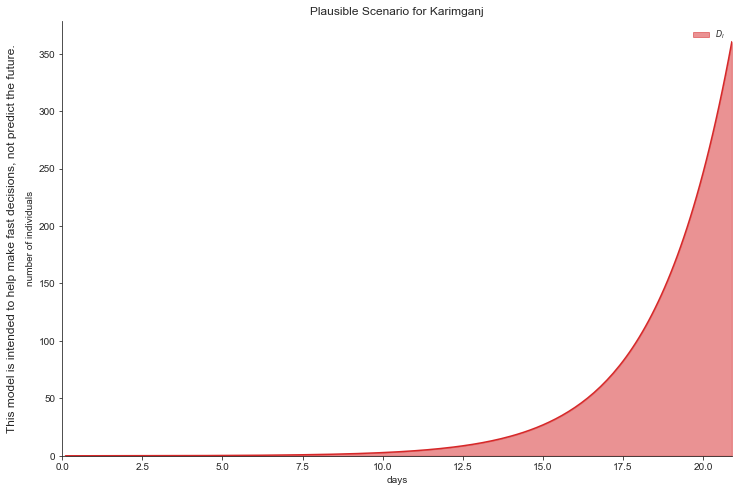

16 360
t = 20.90


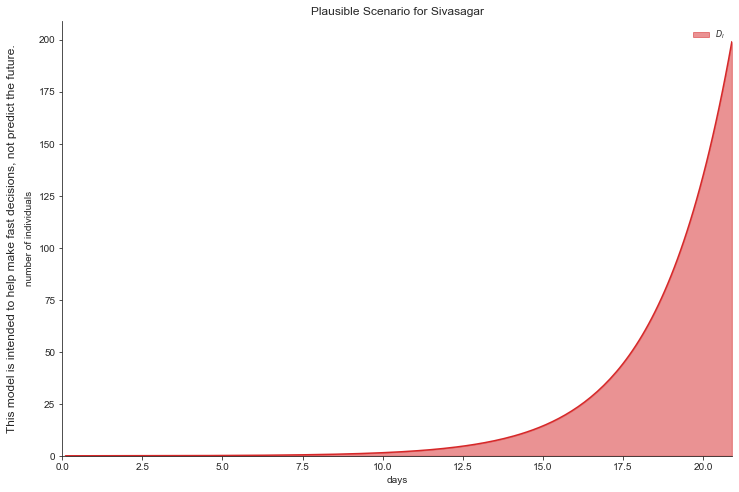

8 199
t = 20.90


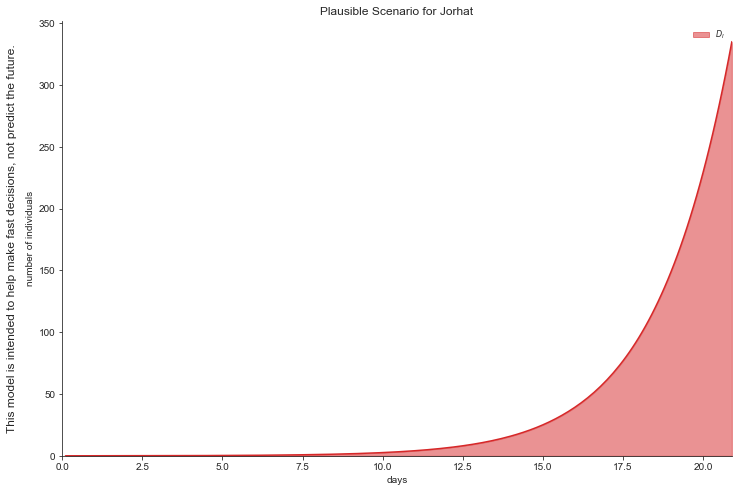

15 335
t = 20.90


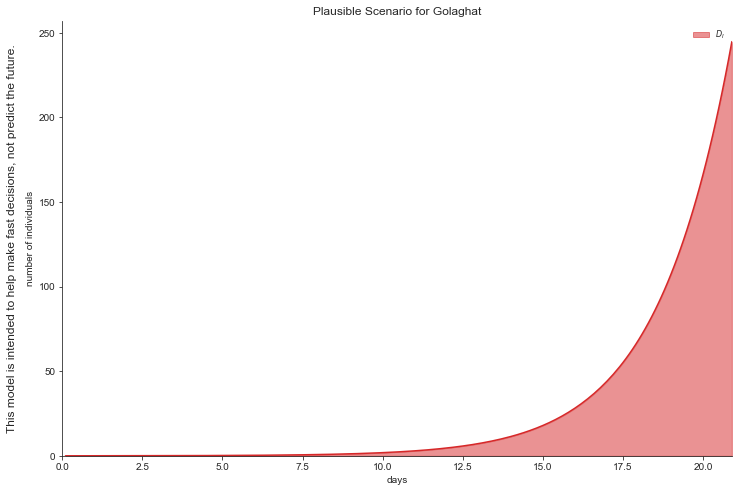

10 244
t = 20.90


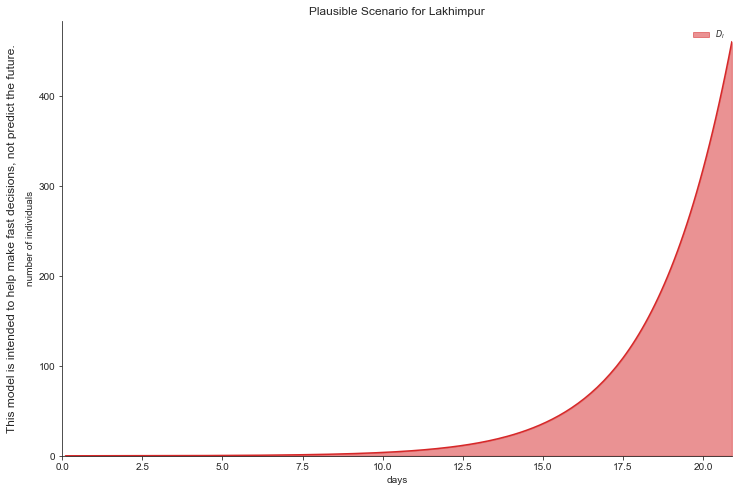

21 460
t = 20.90


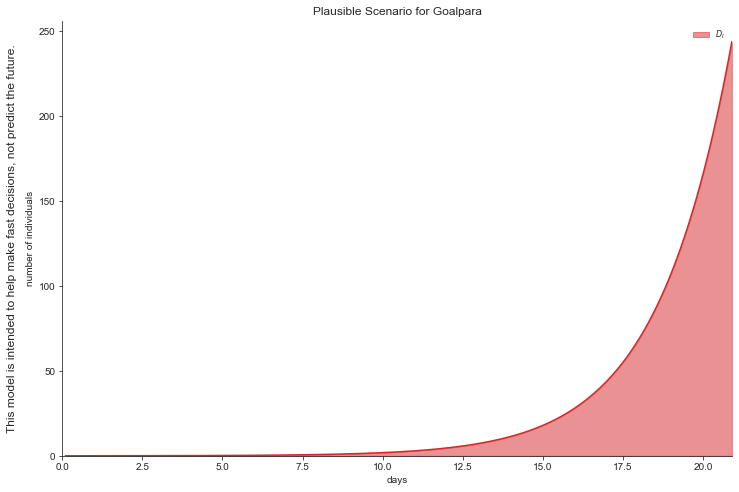

10 243
t = 20.90


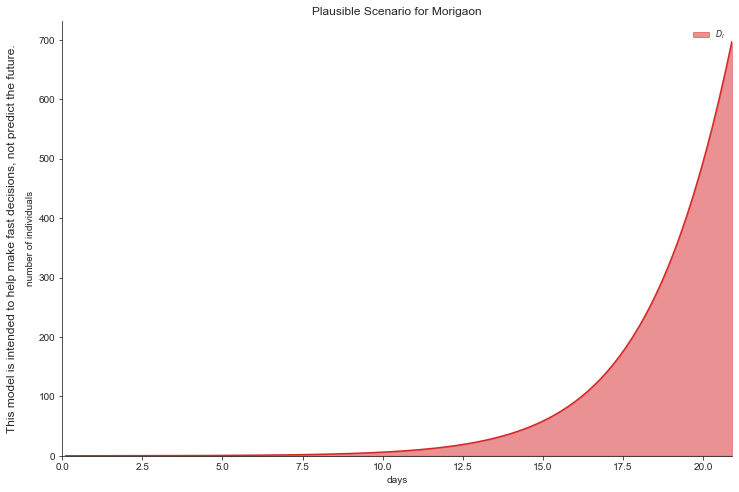

35 697
t = 20.90


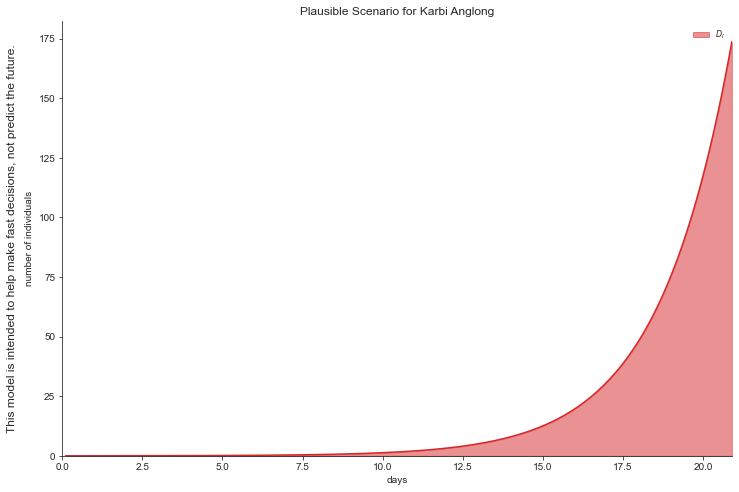

7 173
t = 20.90


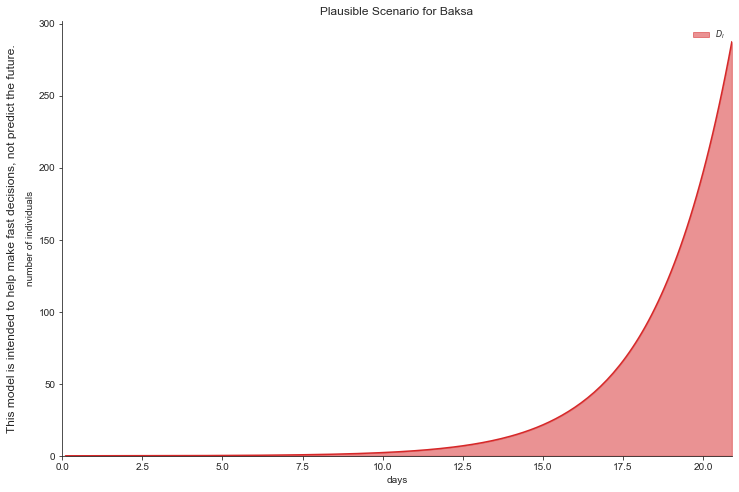

13 287
t = 20.90


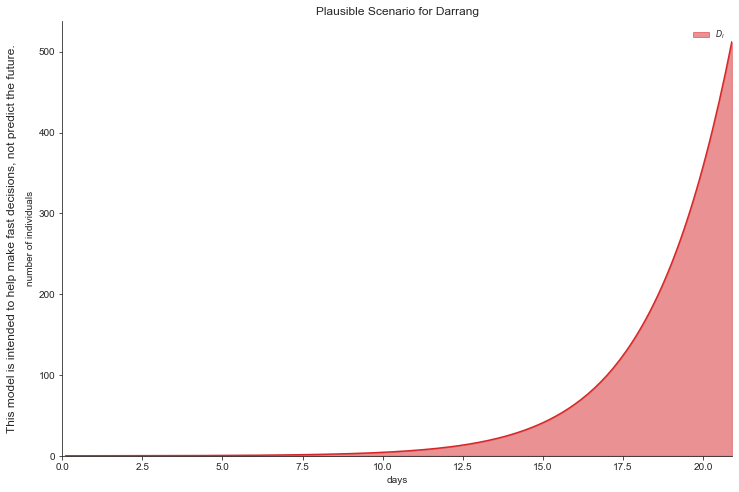

24 512
t = 20.90


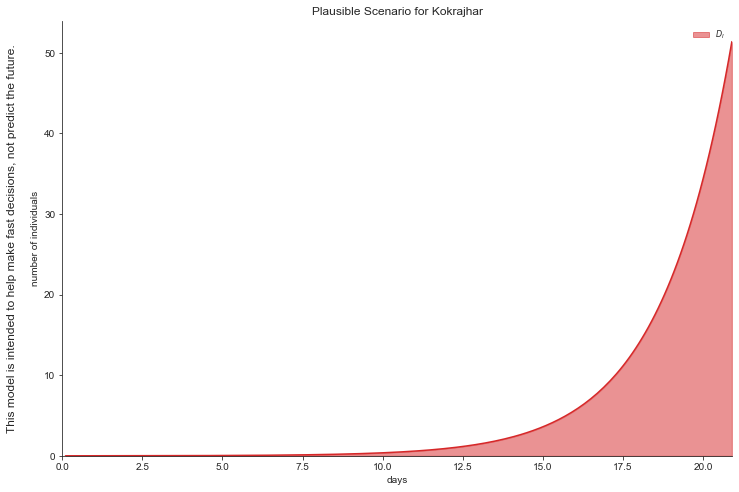

2 51
t = 20.90


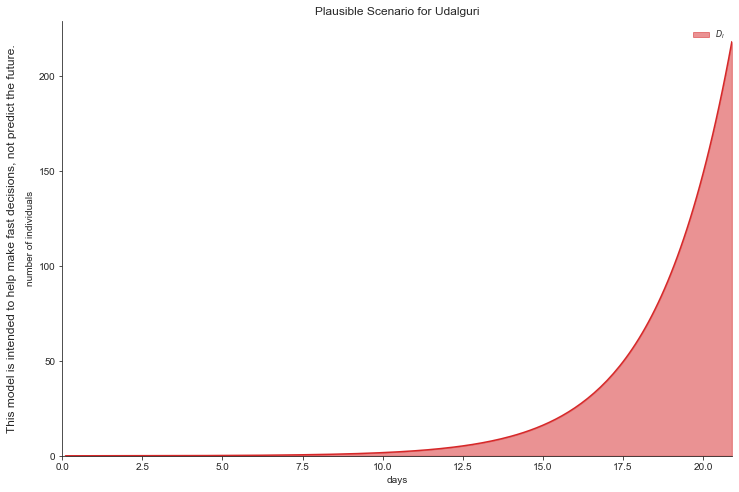

9 218
t = 20.90


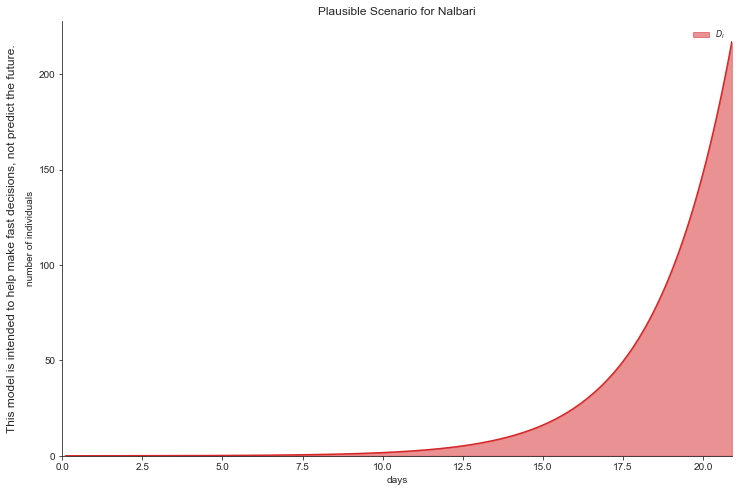

9 217
t = 20.90


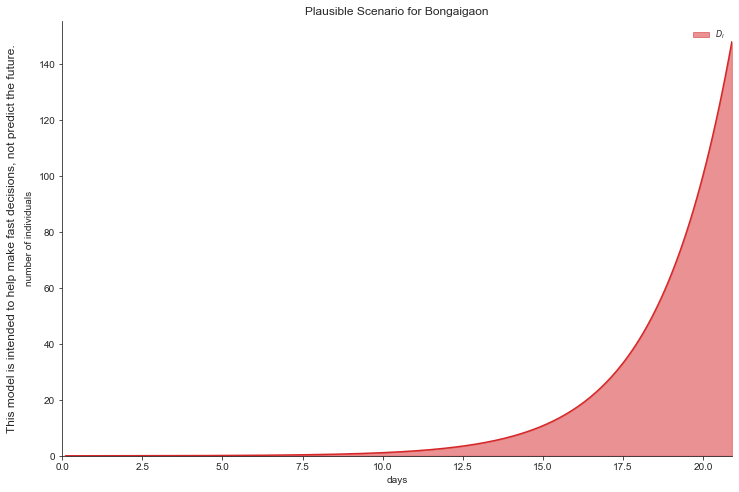

6 148
t = 20.90


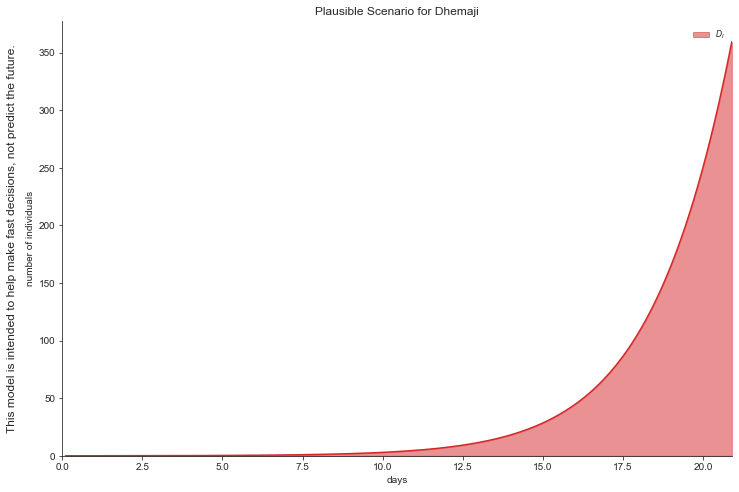

17 359
t = 20.90


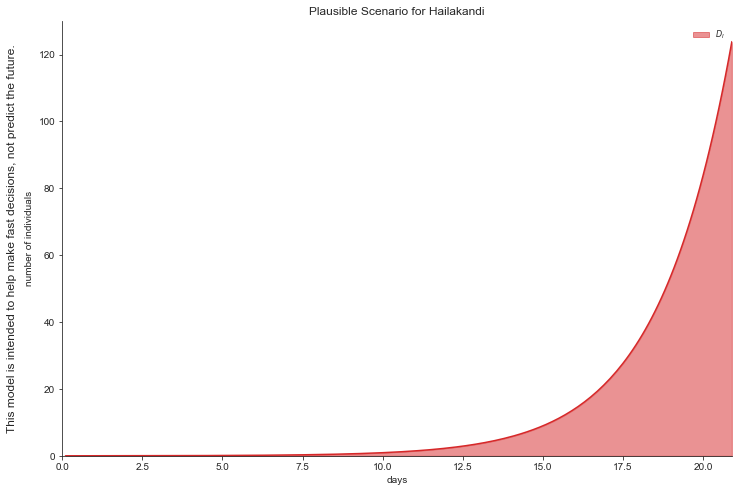

5 123
t = 20.90


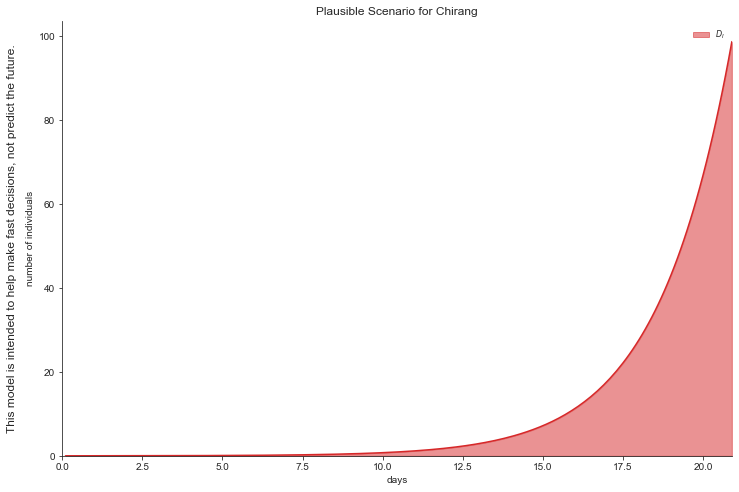

4 98
t = 20.90


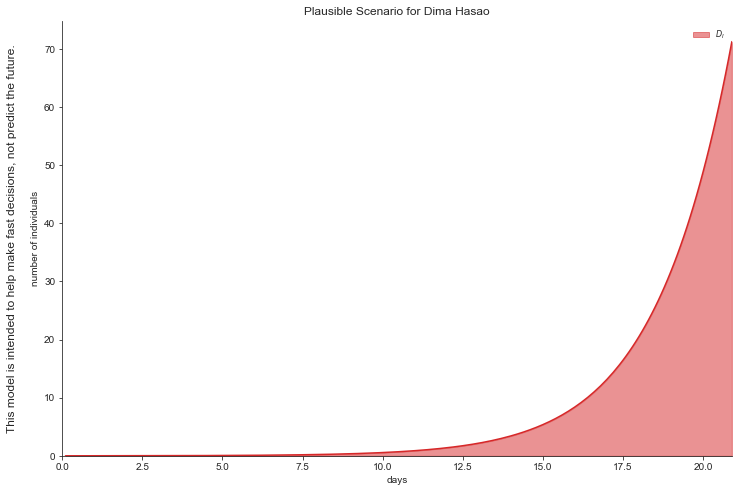

3 71


In [21]:
atrisk_day14, atrisk_day21 = [], []
days_N = 21
for row in assam_estimated_df[["initI", "initN", "District"]].iterrows():
    initI, initN, district = row[1][0], int(row[1][1]), row[1][2]
#     print(type(initI), type(initN))
    infection_results = get_infections(initI=initI, initN=initN, days_N=days_N)
    detected_infected = infection_results["detected_infected"]
    day14 = int(14*len(detected_infected)/days_N)
    case_count_day14 = int(infection_results["detected_infected"][day14])
    case_count_day21 = int(infection_results["detected_infected"][-1])
    infection_results["model"].figure_infections(
        plot_percentages=False,
        plot_D_E=False,
        title=f"Plausible Scenario for {district}",
        side_title="This model is intended to help make fast decisions, not predict the future.", 
        plot_E=False,
        plot_I=False,
        color_D_I="tab:red",
    )
    print(case_count_day14, case_count_day21)
    atrisk_day14.append(case_count_day14)
    atrisk_day21.append(case_count_day21)
#     break

In [19]:
# atrisk_day14, atrisk_day21